In [1]:
!unzip garb.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classific

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score


In [3]:
from torchvision import datasets, transforms

torch.manual_seed(42)

# Путь к данным
data_dir = 'garbage classification/Garbage classification/'

# Преобразование для загрузки данных без нормализации

transform = transforms.Compose([
    transforms.ToTensor()
])

# Загрузка полного набора данных
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Разделение на тренировочную, валидационную и тестовую выборки
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Создаем загрузчик для тренировочной выборки
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# Вычисляем средние и стандартные отклонения по тренировочной выборке

mean = 0.
std = 0.
n_samples = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # количество изображений в батче
    mean += images.mean(dim=(0, 2, 3)) * batch_samples  # Среднее по каналам для текущего батча
    std += images.std(dim=(0, 2, 3)) * batch_samples   # Стандартное отклонение по каналам для текущего батча
    n_samples += batch_samples

# Окончательное среднее и стандартное отклонение по каналам для всего набора данных
mean /= n_samples
std /= n_samples

print(f"Mean per channel: {mean}")
print(f"Std per channel: {std}")


Mean per channel: tensor([0.6748, 0.6410, 0.6053])
Std per channel: tensor([0.2063, 0.2079, 0.2300])


In [4]:
from torchvision import datasets, transforms

torch.manual_seed(42)

# Путь к данным
data_dir = 'garbage classification/Garbage classification/'

# Преобразование для загрузки данных без нормализации
mean = [0.6748, 0.6410, 0.6053]
std = [0.2063, 0.2079, 0.2300]


# Загрузка полного набора данных
dataset = datasets.ImageFolder(root=data_dir)

# Разделение на тренировочную, валидационную и тестовую выборки
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

val_dataset.dataset.transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

test_dataset.dataset.transform = transforms.Compose([
    T.ToTensor(),
    T.Normalize(mean=mean, std=std)
])

# Создание загрузчиков данных
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [5]:
def show_images(dataset, num_images = 10):
    # Создаем подграфик 1x10
    fig, axes = plt.subplots(1, num_images, figsize=(15, 2))

    for i in range(num_images):
        image, label = dataset[i]
        image = image = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {label}")

    plt.show()

Обучающая выборка: 1768 изображений, доля от общей выборки: 0.7


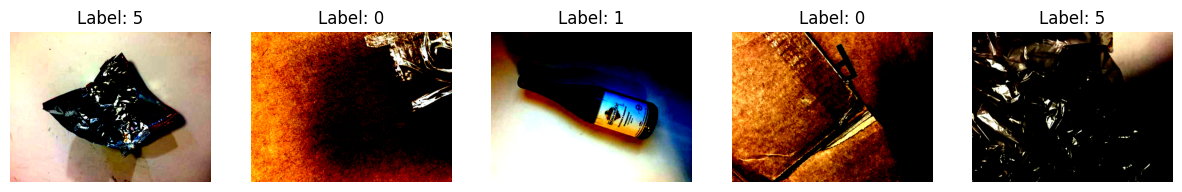

Валидационная выборка: 379 изображений, доля от общей выборки: 0.15


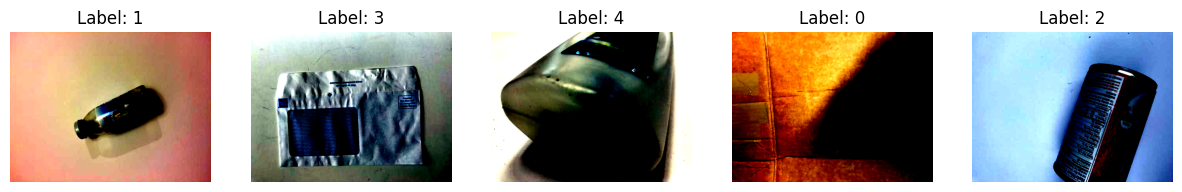

Тестовая выборка: 380 изображений, доля от общей выборки: 0.15


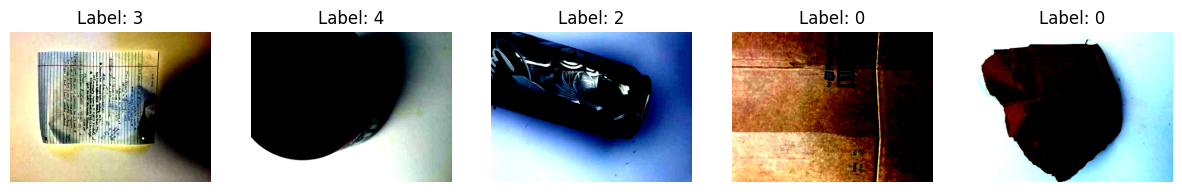

In [6]:
quantity_el_train = len(train_dataset)
quantity_el_val = len(val_dataset)
quantity_el_test = len(test_dataset)

train_ratio = round(len(train_dataset)/len(dataset),3)
val_ratio = round(len(val_dataset)/len(dataset),3)
test_ratio = round(len(test_dataset)/len(dataset),3)

print(f"Обучающая выборка: {quantity_el_train} изображений, доля от общей выборки: {train_ratio}")
show_images(train_dataset, num_images = 5)

print(f"Валидационная выборка: {quantity_el_val} изображений, доля от общей выборки: {val_ratio}")
show_images(val_dataset, num_images = 5)

print(f"Тестовая выборка: {quantity_el_test} изображений, доля от общей выборки: {test_ratio}")
show_images(test_dataset, num_images = 5)

In [7]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def train(model) -> float:
    model.train()

    train_loss = 0
    all_preds = []
    all_labels = []

    for x, y in tqdm(train_loader, desc='Train'):

        bs = y.size(0)

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        # Прямой проход

        output = model(x)

        loss = loss_fn(output, y)

        # Накопление общей потери

        train_loss += loss.item()

        # Обратный проход и обновление весов

        loss.backward()

        optimizer.step()

        # Сбор предсказаний и истинных меток для F1-score
        _, y_pred = output.max(dim=1)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Рассчитываем среднее значение потерь на весь набор данных
    train_loss /= len(train_loader)

    # Рассчитываем Macro F1-score на уровне всего набора данных
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return train_loss, macro_f1


In [8]:
@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    all_preds = []
    all_labels = []

    for x, y in tqdm(loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

    # Рассчитываем среднее значение потерь на весь набор данных
    total_loss /= len(loader)

    # Рассчитываем Macro F1-score на уровне всего набора данных
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss, macro_f1

In [9]:
def whole_train_valid_cycle(model, num_epochs):
    train_loss_history, valid_loss_history = [], []
    train_macro_f1_history, valid_macro_f1_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_macro_f1 = train(model)
        valid_loss, valid_macro_f1 = evaluate(model, val_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_macro_f1_history.append(train_macro_f1)
        valid_macro_f1_history.append(valid_macro_f1)

        print(f"Эпоха {epoch+1}")
        print(f"___Train___ Loss = {train_loss}, Macro_F1 = {train_macro_f1}")
        print(f"___Test___  Loss = {valid_loss}, Macro_F1 = {valid_macro_f1}")

    return train_macro_f1_history, valid_macro_f1_history, train_loss_history, valid_loss_history


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [11]:
from torchvision.models import googlenet, resnet50, vgg16, inception_v3
import torch.nn as nn

resnet_1 = resnet50(pretrained=True)
resnet_1.fc = nn.Linear(resnet_1.fc.in_features, 6)
for param in resnet_1.parameters():
    param.requires_grad = False
resnet_1.fc.weight.requires_grad = True
resnet_1.fc.bias.requires_grad = True

googlenet_1 = googlenet(pretrained=True)
googlenet_1.fc = nn.Linear(googlenet_1.fc.in_features, 6)
for param in googlenet_1.parameters():
    param.requires_grad = False
googlenet_1.fc.weight.requires_grad = True
googlenet_1.fc.bias.requires_grad = True

inception_1 = inception_v3(pretrained=True)
inception_1.fc = nn.Linear(inception_1.fc.in_features, 6)
for param in inception_1.parameters():
    param.requires_grad = False
inception_1.fc.weight.requires_grad = True
inception_1.fc.bias.requires_grad = True
inception_1.aux_logits = False

vgg_1 = vgg16(pretrained=True)
vgg_1.classifier[6] = nn.Linear(vgg_1.classifier[6].in_features, 6)
for param in vgg_1.parameters():
    param.requires_grad = False
vgg_1.classifier[6].weight.requires_grad = True
vgg_1.classifier[6].bias.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [12]:
num_epochs = 15
loss_fn = nn.CrossEntropyLoss()

#Inception
print("Inception обучение классификатора")
inception_1.to(device)
optimizer = optim.Adam(inception_1.parameters(), lr=0.001)

train_macro_f1_history_inception_1, valid_macro_f1_history_inception_1, train_loss_history_inception_1, valid_loss_history_inception_1 = whole_train_valid_cycle(inception_1,
                                                                                                                                                         num_epochs = num_epochs)

#Vgg
print("Vgg обучение классификатора")
vgg_1.to(device)
optimizer = optim.Adam(vgg_1.parameters(), lr=0.001)

train_macro_f1_history_vgg_1, valid_macro_f1_history_vgg_1, train_loss_history_vgg_1, valid_loss_history_vgg_1 = whole_train_valid_cycle(vgg_1,
                                                                                                                                         num_epochs = num_epochs)

#Googlenet
print("Googlenet обучение классификатора")
googlenet_1.to(device)
optimizer = optim.Adam(googlenet_1.parameters(), lr=0.001)

train_macro_f1_history_googlenet_1, valid_macro_f1_history_googlenet_1, train_loss_history_googlenet_1, valid_loss_history_googlenet_1 = whole_train_valid_cycle(googlenet_1,
                                                                                                                                                             num_epochs = num_epochs)

#Resnet
print("Resnet обучение классификатора")
resnet_1.to(device)
optimizer = optim.Adam(resnet_1.parameters(), lr=0.001)

train_macro_f1_history_resnet_1, valid_macro_f1_history_resnet_1, train_loss_history_resnet_1, valid_loss_history_resnet_1 = whole_train_valid_cycle(resnet_1,
                                                                                                                                                     num_epochs = num_epochs)

Inception обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Эпоха 1
___Train___ Loss = 1.527169896023614, Macro_F1 = 0.3536821718557714
___Test___  Loss = 1.359038809935252, Macro_F1 = 0.37557938476725256


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Эпоха 2
___Train___ Loss = 1.1678427649395806, Macro_F1 = 0.5465499671594766
___Test___  Loss = 1.0649086833000183, Macro_F1 = 0.5974747577353946


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Эпоха 3
___Train___ Loss = 0.9856032878160477, Macro_F1 = 0.6152576796956991
___Test___  Loss = 0.9394282400608063, Macro_F1 = 0.6319741109800654


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


Эпоха 4
___Train___ Loss = 0.8716768962996346, Macro_F1 = 0.6780234437592942
___Test___  Loss = 0.8849121828873953, Macro_F1 = 0.6748183962848845


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Эпоха 5
___Train___ Loss = 0.8246771629367556, Macro_F1 = 0.6759005183548905
___Test___  Loss = 0.8048073450724283, Macro_F1 = 0.6978916638916638


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 6
___Train___ Loss = 0.7515774560826165, Macro_F1 = 0.7183980168287155
___Test___  Loss = 0.7695395251115164, Macro_F1 = 0.7067761864324963


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Эпоха 7
___Train___ Loss = 0.7215264247996467, Macro_F1 = 0.734935136694892
___Test___  Loss = 0.7269929647445679, Macro_F1 = 0.7277743070521577


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Эпоха 8
___Train___ Loss = 0.7032247547592435, Macro_F1 = 0.7190370981362505
___Test___  Loss = 0.6972916920979818, Macro_F1 = 0.7123785861187878


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


Эпоха 9
___Train___ Loss = 0.6724380329251289, Macro_F1 = 0.7474624665948038
___Test___  Loss = 0.6888646384080251, Macro_F1 = 0.7154586319597217


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Эпоха 10
___Train___ Loss = 0.6352227032184601, Macro_F1 = 0.7591459283001614
___Test___  Loss = 0.6509884099165598, Macro_F1 = 0.7641583678952698


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.18it/s]


Эпоха 11
___Train___ Loss = 0.6106268380369458, Macro_F1 = 0.7740578333437713
___Test___  Loss = 0.6622786223888397, Macro_F1 = 0.7326857909075292


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 12
___Train___ Loss = 0.6002791140760694, Macro_F1 = 0.7745743335886637
___Test___  Loss = 0.6490689913431803, Macro_F1 = 0.7325033376218294


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 13
___Train___ Loss = 0.5869732009513038, Macro_F1 = 0.773514104212079
___Test___  Loss = 0.6194676756858826, Macro_F1 = 0.7680812405470019


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 14
___Train___ Loss = 0.5973389648965427, Macro_F1 = 0.7611750232725885
___Test___  Loss = 0.6095117727915446, Macro_F1 = 0.7568123658638809


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 15
___Train___ Loss = 0.5644337024007525, Macro_F1 = 0.7867735863930777
___Test___  Loss = 0.6007766077915827, Macro_F1 = 0.7515461019181159
Vgg обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Эпоха 1
___Train___ Loss = 1.0135627346379417, Macro_F1 = 0.5867091930871462
___Test___  Loss = 0.7111104230086008, Macro_F1 = 0.7452938036850334


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 2
___Train___ Loss = 0.608831059719835, Macro_F1 = 0.7488130720404641
___Test___  Loss = 0.5913657148679098, Macro_F1 = 0.7700818333958782


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 3
___Train___ Loss = 0.5012081648622241, Macro_F1 = 0.7987006636456137
___Test___  Loss = 0.5591896325349808, Macro_F1 = 0.784724971123053


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 4
___Train___ Loss = 0.4540447071194649, Macro_F1 = 0.8290766490846244
___Test___  Loss = 0.5317759066820145, Macro_F1 = 0.8217909923805667


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


Эпоха 5
___Train___ Loss = 0.4319486011351858, Macro_F1 = 0.8292779983189349
___Test___  Loss = 0.5066276341676712, Macro_F1 = 0.8153265120740439


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.62s/it]


Эпоха 6
___Train___ Loss = 0.40737591896738323, Macro_F1 = 0.8465603706892234
___Test___  Loss = 0.5009955565134684, Macro_F1 = 0.8120681897380232


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 7
___Train___ Loss = 0.37059799475329264, Macro_F1 = 0.8566363581415127
___Test___  Loss = 0.5060540586709976, Macro_F1 = 0.7837284390409326


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 8
___Train___ Loss = 0.3584929348102638, Macro_F1 = 0.8755713199005281
___Test___  Loss = 0.49129518866539, Macro_F1 = 0.8096036631355176


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 9
___Train___ Loss = 0.35009984033448355, Macro_F1 = 0.8701529110590075
___Test___  Loss = 0.4936471184094747, Macro_F1 = 0.8016877463384576


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Эпоха 10
___Train___ Loss = 0.3351242446473667, Macro_F1 = 0.8707215978215775
___Test___  Loss = 0.4799030274152756, Macro_F1 = 0.8031261632409153


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 11
___Train___ Loss = 0.3172987076853003, Macro_F1 = 0.8811209667790147
___Test___  Loss = 0.45948684215545654, Macro_F1 = 0.8219816706240067


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.52s/it]


Эпоха 12
___Train___ Loss = 0.32025210931897163, Macro_F1 = 0.8697636301044266
___Test___  Loss = 0.4445714553197225, Macro_F1 = 0.8347068928334327


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 13
___Train___ Loss = 0.30014372510569437, Macro_F1 = 0.8816525338450996
___Test___  Loss = 0.4527724285920461, Macro_F1 = 0.819692922011749


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Эпоха 14
___Train___ Loss = 0.30190836478556904, Macro_F1 = 0.8876435298248501
___Test___  Loss = 0.49325130879879, Macro_F1 = 0.800014727662513


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.51s/it]


Эпоха 15
___Train___ Loss = 0.28729034481304033, Macro_F1 = 0.8942750803797899
___Test___  Loss = 0.45824363827705383, Macro_F1 = 0.8161953029548847
Googlenet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Эпоха 1
___Train___ Loss = 1.5333421230316162, Macro_F1 = 0.3444231126528765
___Test___  Loss = 1.349018156528473, Macro_F1 = 0.4502961217476562


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


Эпоха 2
___Train___ Loss = 1.1873908170631953, Macro_F1 = 0.5565503468121495
___Test___  Loss = 1.1217458645502727, Macro_F1 = 0.5808620014853992


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Эпоха 3
___Train___ Loss = 1.0083139538764954, Macro_F1 = 0.6035407524859564
___Test___  Loss = 0.9825977683067322, Macro_F1 = 0.6322736067961717


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Эпоха 4
___Train___ Loss = 0.8939233039106641, Macro_F1 = 0.6624883760837251
___Test___  Loss = 0.8922175367673238, Macro_F1 = 0.6832542373326298


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Эпоха 5
___Train___ Loss = 0.8065107933112553, Macro_F1 = 0.7090279649954135
___Test___  Loss = 0.8476191560427347, Macro_F1 = 0.6468254882934048


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


Эпоха 6
___Train___ Loss = 0.7505982518196106, Macro_F1 = 0.7364178355245525
___Test___  Loss = 0.7848162949085236, Macro_F1 = 0.7140348468407942


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Эпоха 7
___Train___ Loss = 0.7126810699701309, Macro_F1 = 0.7517638549452569
___Test___  Loss = 0.7448010742664337, Macro_F1 = 0.7099048778410055


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Эпоха 8
___Train___ Loss = 0.666650693331446, Macro_F1 = 0.7634487892756737
___Test___  Loss = 0.7287777264912924, Macro_F1 = 0.7359661446275457


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]


Эпоха 9
___Train___ Loss = 0.6437624905790601, Macro_F1 = 0.7681116722115711
___Test___  Loss = 0.6998386979103088, Macro_F1 = 0.7312289804416765


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


Эпоха 10
___Train___ Loss = 0.6030855168189321, Macro_F1 = 0.7937675519559398
___Test___  Loss = 0.6590654949347178, Macro_F1 = 0.749219395966812


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]


Эпоха 11
___Train___ Loss = 0.6072177407996995, Macro_F1 = 0.7826099241045202
___Test___  Loss = 0.6382591426372528, Macro_F1 = 0.7442483232805263


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Эпоха 12
___Train___ Loss = 0.5528015483702932, Macro_F1 = 0.8150801124614269
___Test___  Loss = 0.6318877140680949, Macro_F1 = 0.732802505091839


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 13
___Train___ Loss = 0.5480558808360781, Macro_F1 = 0.8009187424858258
___Test___  Loss = 0.6159881850083669, Macro_F1 = 0.7690611284817389


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Эпоха 14
___Train___ Loss = 0.5414127675550324, Macro_F1 = 0.8110801619107838
___Test___  Loss = 0.5889992614587148, Macro_F1 = 0.7558554238419118


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Эпоха 15
___Train___ Loss = 0.5359289071389607, Macro_F1 = 0.7994738040537493
___Test___  Loss = 0.5799708863099416, Macro_F1 = 0.7619037434365774
Resnet обучение классификатора


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Эпоха 1
___Train___ Loss = 1.299067742058209, Macro_F1 = 0.46298781968032143
___Test___  Loss = 1.0132422248522441, Macro_F1 = 0.5378770547070215


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 2
___Train___ Loss = 0.8468254783323833, Macro_F1 = 0.656932878540701
___Test___  Loss = 0.7640128135681152, Macro_F1 = 0.7427779047317621


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 3
___Train___ Loss = 0.6962175816297531, Macro_F1 = 0.7759448663846956
___Test___  Loss = 0.6798433562119802, Macro_F1 = 0.7123873337448875


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 4
___Train___ Loss = 0.6028771347233227, Macro_F1 = 0.7899886358709205
___Test___  Loss = 0.6368626157442728, Macro_F1 = 0.732339279180667


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 5
___Train___ Loss = 0.5499263969915253, Macro_F1 = 0.8320775429989045
___Test___  Loss = 0.5802474121252695, Macro_F1 = 0.787838621051281


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.04s/it]


Эпоха 6
___Train___ Loss = 0.5013867701802935, Macro_F1 = 0.8494447527575559
___Test___  Loss = 0.548823207616806, Macro_F1 = 0.7906400985151852


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 7
___Train___ Loss = 0.4654252656868526, Macro_F1 = 0.8551860492815164
___Test___  Loss = 0.5266801019509634, Macro_F1 = 0.8095586185928917


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 8
___Train___ Loss = 0.4323799429195268, Macro_F1 = 0.8743467134077104
___Test___  Loss = 0.5225399533907572, Macro_F1 = 0.8110953153670057


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 9
___Train___ Loss = 0.4160793519445828, Macro_F1 = 0.8702356132041357
___Test___  Loss = 0.5089325308799744, Macro_F1 = 0.7939163325476791


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 10
___Train___ Loss = 0.3982133152229445, Macro_F1 = 0.8705008348472885
___Test___  Loss = 0.49951760470867157, Macro_F1 = 0.8048715933746428


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 11
___Train___ Loss = 0.36900473492486136, Macro_F1 = 0.8956383072228951
___Test___  Loss = 0.46101635197798413, Macro_F1 = 0.8330647167074967


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 12
___Train___ Loss = 0.3657091526048524, Macro_F1 = 0.8772585491665662
___Test___  Loss = 0.4837732215722402, Macro_F1 = 0.7767307358704705


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


Эпоха 13
___Train___ Loss = 0.34571987656610353, Macro_F1 = 0.8992412856620405
___Test___  Loss = 0.46035393079121906, Macro_F1 = 0.8272941869096889


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]


Эпоха 14
___Train___ Loss = 0.33150320979101316, Macro_F1 = 0.8991939485885778
___Test___  Loss = 0.4423082172870636, Macro_F1 = 0.8171124427904987


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

Эпоха 15
___Train___ Loss = 0.3335941050733839, Macro_F1 = 0.9007171028677535
___Test___  Loss = 0.43494101862112683, Macro_F1 = 0.8217259577932277


In [13]:
from torchvision.models import googlenet, resnet50, vgg16, inception_v3
import torch.nn as nn

resnet = resnet50(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, 6)


googlenet = googlenet(pretrained=True)
googlenet.fc = nn.Linear(googlenet.fc.in_features, 6)


inception = inception_v3(pretrained=True)
inception.fc = nn.Linear(inception.fc.in_features, 6)
inception.aux_logits = False

vgg = vgg16(pretrained=True)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 6)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date we

In [14]:
from torch.optim import Adam

num_epochs = 15
loss_fn = nn.CrossEntropyLoss()

# Inception
for param in inception.parameters():
    param.requires_grad = False
# Разморозим `Mixed_7c` и классификатор
for param in inception.Mixed_7c.parameters():
    param.requires_grad = True
for param in inception.fc.parameters():
    param.requires_grad = True

print("Inception: обучение Mixed_7c и fc")
inception.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, inception.parameters()), lr=0.001)

train_macro_f1_history_inception, valid_macro_f1_history_inception, train_loss_history_inception, valid_loss_history_inception = whole_train_valid_cycle(
    inception, num_epochs=num_epochs)

# GoogLeNet
for param in googlenet.parameters():
    param.requires_grad = False
# Разморозим последние два слоя: `inception5b` и классификатор
for param in googlenet.inception5b.parameters():
    param.requires_grad = True
for param in googlenet.fc.parameters():
    param.requires_grad = True

print("GoogLeNet: обучение inception5b и fc")
googlenet.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, googlenet.parameters()), lr=0.001)

train_macro_f1_history_googlenet, valid_macro_f1_history_googlenet, train_loss_history_googlenet, valid_loss_history_googlenet = whole_train_valid_cycle(
    googlenet, num_epochs=num_epochs)

# ResNet50
for param in resnet.parameters():
    param.requires_grad = False
# Разморозим последний блок ResNet (`layer4`) и классификатор
for param in resnet.layer4.parameters():
    param.requires_grad = True
for param in resnet.fc.parameters():
    param.requires_grad = True

print("ResNet50: обучение layer4 и fc")
resnet.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)

train_macro_f1_history_resnet, valid_macro_f1_history_resnet, train_loss_history_resnet, valid_loss_history_resnet = whole_train_valid_cycle(
    resnet, num_epochs=num_epochs)

# VGG16
for param in vgg.parameters():
    param.requires_grad = False
# Разморозим последние 4 сверточных слоя и классификатор
for param in vgg.features[-8:].parameters():
    param.requires_grad = True
for param in vgg.classifier.parameters():
    param.requires_grad = True

print("VGG16: обучение последних 4-х сверточных слоев и классификатора")
vgg.to(device)
optimizer = Adam(filter(lambda p: p.requires_grad, vgg.parameters()), lr=0.001)

train_macro_f1_history_vgg, valid_macro_f1_history_vgg, train_loss_history_vgg, valid_loss_history_vgg = whole_train_valid_cycle(
    vgg, num_epochs=num_epochs)

Inception: обучение Mixed_7c и fc


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Эпоха 1
___Train___ Loss = 0.6595741670046534, Macro_F1 = 0.7060733553608625
___Test___  Loss = 0.46680370966593426, Macro_F1 = 0.8505918598590262


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.11it/s]


Эпоха 2
___Train___ Loss = 0.14778316020965576, Macro_F1 = 0.9406714404597599
___Test___  Loss = 0.29117684811353683, Macro_F1 = 0.8889793214757207


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s]


Эпоха 3
___Train___ Loss = 0.03326777994100537, Macro_F1 = 0.9945808015354521
___Test___  Loss = 0.2918456519643466, Macro_F1 = 0.8956719827029493


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 4
___Train___ Loss = 0.01278406206152535, Macro_F1 = 0.9980173249523094
___Test___  Loss = 0.27537750949462253, Macro_F1 = 0.8870833446605464


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.15it/s]


Эпоха 5
___Train___ Loss = 0.013199921040463128, Macro_F1 = 0.9963927759369097
___Test___  Loss = 0.3040117720762889, Macro_F1 = 0.8800866247468752


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


Эпоха 6
___Train___ Loss = 0.01614449534931087, Macro_F1 = 0.9974863662638728
___Test___  Loss = 0.2897743806242943, Macro_F1 = 0.8801889891077042


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Эпоха 7
___Train___ Loss = 0.007628839034753453, Macro_F1 = 0.9980157575570234
___Test___  Loss = 0.2930542081594467, Macro_F1 = 0.8876787260892173


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Эпоха 8
___Train___ Loss = 0.008055190651378195, Macro_F1 = 0.996471454766975
___Test___  Loss = 0.241278146704038, Macro_F1 = 0.8994955746226373


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 9
___Train___ Loss = 0.004724054884198787, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.25747838368018466, Macro_F1 = 0.9016912410586766


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Эпоха 10
___Train___ Loss = 0.005106725528353958, Macro_F1 = 0.9990315144359169
___Test___  Loss = 0.2637642174959183, Macro_F1 = 0.903017878942169


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.13it/s]


Эпоха 11
___Train___ Loss = 0.003956194925454578, Macro_F1 = 0.9984851214862035
___Test___  Loss = 0.2783065661787987, Macro_F1 = 0.8990908253345088


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 12
___Train___ Loss = 0.004533683032994824, Macro_F1 = 0.9975145044241914
___Test___  Loss = 0.2625155871113141, Macro_F1 = 0.8980339531757972


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.06it/s]


Эпоха 13
___Train___ Loss = 0.0038986965810181573, Macro_F1 = 0.9985471399321436
___Test___  Loss = 0.2658671662211418, Macro_F1 = 0.8963617939145707


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


Эпоха 14
___Train___ Loss = 0.0034448903565394823, Macro_F1 = 0.9990313347054921
___Test___  Loss = 0.2555835321545601, Macro_F1 = 0.9018508712145756


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.08it/s]


Эпоха 15
___Train___ Loss = 0.0023960846701811533, Macro_F1 = 0.9990311385598417
___Test___  Loss = 0.265366127093633, Macro_F1 = 0.9021623015087067
GoogLeNet: обучение inception5b и fc


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]


Эпоха 1
___Train___ Loss = 0.8933153535638537, Macro_F1 = 0.6258259218637227
___Test___  Loss = 0.5547010600566864, Macro_F1 = 0.7487383584142062


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


Эпоха 2
___Train___ Loss = 0.39595997227089746, Macro_F1 = 0.849580052043554
___Test___  Loss = 0.4233168164889018, Macro_F1 = 0.8070037921964968


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 3
___Train___ Loss = 0.22611121780106, Macro_F1 = 0.9209593563051697
___Test___  Loss = 0.35678553581237793, Macro_F1 = 0.8565878571274256


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


Эпоха 4
___Train___ Loss = 0.1248181824173246, Macro_F1 = 0.9650842603438635
___Test___  Loss = 0.3218209594488144, Macro_F1 = 0.8628405931742358


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.48it/s]


Эпоха 5
___Train___ Loss = 0.06581423498157944, Macro_F1 = 0.9897056103769906
___Test___  Loss = 0.32091272870699566, Macro_F1 = 0.8687550776927956


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Эпоха 6
___Train___ Loss = 0.03781008261388966, Macro_F1 = 0.99797116534161
___Test___  Loss = 0.2923947870731354, Macro_F1 = 0.8780523024498929


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


Эпоха 7
___Train___ Loss = 0.02608680059867246, Macro_F1 = 0.9984997462305071
___Test___  Loss = 0.2615181729197502, Macro_F1 = 0.8847091850226675


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 8
___Train___ Loss = 0.01708931931560593, Macro_F1 = 0.998062669410984
___Test___  Loss = 0.2881435677409172, Macro_F1 = 0.8782752532752531


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 9
___Train___ Loss = 0.013609930872917175, Macro_F1 = 0.9985471399321436
___Test___  Loss = 0.276229922970136, Macro_F1 = 0.8845710754491704


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]


Эпоха 10
___Train___ Loss = 0.01305427503705557, Macro_F1 = 0.9990313347054921
___Test___  Loss = 0.29161033034324646, Macro_F1 = 0.8713436549529264


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


Эпоха 11
___Train___ Loss = 0.011955951157558178, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.2806713556249936, Macro_F1 = 0.8833343752856528


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 12
___Train___ Loss = 0.008385261346120387, Macro_F1 = 0.9990315144359169
___Test___  Loss = 0.2857308064897855, Macro_F1 = 0.8705824608607262


Evaluation: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Эпоха 13
___Train___ Loss = 0.010346496527615403, Macro_F1 = 0.9985468580286622
___Test___  Loss = 0.277240552008152, Macro_F1 = 0.8792725793698289


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Эпоха 14
___Train___ Loss = 0.008044629981408693, Macro_F1 = 0.9985471399321436
___Test___  Loss = 0.2728257377942403, Macro_F1 = 0.8831731105892412


Evaluation: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]


Эпоха 15
___Train___ Loss = 0.007448552192987076, Macro_F1 = 0.9990311385598417
___Test___  Loss = 0.26589227964480716, Macro_F1 = 0.8895423779031831
ResNet50: обучение layer4 и fc


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 1
___Train___ Loss = 0.6488852724432945, Macro_F1 = 0.7141126784752551
___Test___  Loss = 1.23236483335495, Macro_F1 = 0.7520493841998587


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.00it/s]


Эпоха 2
___Train___ Loss = 0.24762209571365798, Macro_F1 = 0.910007344563475
___Test___  Loss = 0.5426359872023264, Macro_F1 = 0.868025773260568


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 3
___Train___ Loss = 0.11689208274973291, Macro_F1 = 0.9544770103343323
___Test___  Loss = 0.3068232337633769, Macro_F1 = 0.8886890152238283


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.07s/it]


Эпоха 4
___Train___ Loss = 0.0718169738205948, Macro_F1 = 0.9636976716649742
___Test___  Loss = 0.32723842561244965, Macro_F1 = 0.8699665212858831


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 5
___Train___ Loss = 0.04976953070477715, Macro_F1 = 0.9796531043770315
___Test___  Loss = 0.5115303744872411, Macro_F1 = 0.870308479080227


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 6
___Train___ Loss = 0.03183018382904785, Macro_F1 = 0.9892030629641179
___Test___  Loss = 0.5688946396112442, Macro_F1 = 0.8778794193384661


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 7
___Train___ Loss = 0.03266211676444592, Macro_F1 = 0.9883128058674799
___Test___  Loss = 0.3137187374134858, Macro_F1 = 0.9181556561959227


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


Эпоха 8
___Train___ Loss = 0.03825352087317567, Macro_F1 = 0.9856467062263525
___Test___  Loss = 0.338884765903155, Macro_F1 = 0.9010433112157609


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 9
___Train___ Loss = 0.03009808375333835, Macro_F1 = 0.9862699693219753
___Test___  Loss = 0.374730683863163, Macro_F1 = 0.8960202581119462


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]


Эпоха 10
___Train___ Loss = 0.02209937209408963, Macro_F1 = 0.9949736256676159
___Test___  Loss = 0.3902677645285924, Macro_F1 = 0.8864157193935543


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]


Эпоха 11
___Train___ Loss = 0.06624633364845067, Macro_F1 = 0.9793101189863277
___Test___  Loss = 1.5749216079711914, Macro_F1 = 0.7370445876862265


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Эпоха 12
___Train___ Loss = 0.05254775643282171, Macro_F1 = 0.9870194257660865
___Test___  Loss = 0.6411674420038859, Macro_F1 = 0.8440223303722977


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 13
___Train___ Loss = 0.030012589376253476, Macro_F1 = 0.9913127500985381
___Test___  Loss = 0.42736731966336566, Macro_F1 = 0.8821949132973957


Evaluation: 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]


Эпоха 14
___Train___ Loss = 0.032275544541854675, Macro_F1 = 0.9879319404620249
___Test___  Loss = 0.45867769171794254, Macro_F1 = 0.8897633106784912


Evaluation: 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]


Эпоха 15
___Train___ Loss = 0.025613154338706017, Macro_F1 = 0.9846340730883446
___Test___  Loss = 0.4066694652040799, Macro_F1 = 0.8802589577276404
VGG16: обучение последних 4-х сверточных слоев и классификатора


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.56s/it]


Эпоха 1
___Train___ Loss = 2.0393005992685045, Macro_F1 = 0.2928002235098673
___Test___  Loss = 1.5341041882832844, Macro_F1 = 0.34752532643087725


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.55s/it]


Эпоха 2
___Train___ Loss = 1.4046293795108795, Macro_F1 = 0.37955107169545005
___Test___  Loss = 1.5260983506838481, Macro_F1 = 0.29266140280724934


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.53s/it]


Эпоха 3
___Train___ Loss = 1.4019617864063807, Macro_F1 = 0.3434732948536762
___Test___  Loss = 1.5345461169878643, Macro_F1 = 0.3142581179890394


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 4
___Train___ Loss = 1.2381288153784615, Macro_F1 = 0.4041839806649438
___Test___  Loss = 1.3339390556017559, Macro_F1 = 0.3268452748043405


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


Эпоха 5
___Train___ Loss = 1.1042329732860838, Macro_F1 = 0.43317587786513084
___Test___  Loss = 1.1714537739753723, Macro_F1 = 0.4682505091182796


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 6
___Train___ Loss = 0.970184536916869, Macro_F1 = 0.5428002939829232
___Test___  Loss = 1.2547344168027241, Macro_F1 = 0.4921394826882632


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.61s/it]


Эпоха 7
___Train___ Loss = 0.8959783975567136, Macro_F1 = 0.5979670227391173
___Test___  Loss = 1.0718142092227936, Macro_F1 = 0.5887070800571613


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Эпоха 8
___Train___ Loss = 0.7770876054252897, Macro_F1 = 0.6495716091142049
___Test___  Loss = 1.0299048721790314, Macro_F1 = 0.5948765063438977


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Эпоха 9
___Train___ Loss = 0.687264336006982, Macro_F1 = 0.7041464853911731
___Test___  Loss = 1.2106292645136516, Macro_F1 = 0.6136866522592003


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 10
___Train___ Loss = 0.7142267589058194, Macro_F1 = 0.7144969460486484
___Test___  Loss = 1.1217493911584218, Macro_F1 = 0.596796924733007


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 11
___Train___ Loss = 0.6121363533394677, Macro_F1 = 0.7424971250940332
___Test___  Loss = 1.2317438622315724, Macro_F1 = 0.6304306143478756


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]


Эпоха 12
___Train___ Loss = 0.583695829979011, Macro_F1 = 0.758849410385054
___Test___  Loss = 1.0937609871228535, Macro_F1 = 0.6181043348057599


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 13
___Train___ Loss = 0.540951998106071, Macro_F1 = 0.7741045267359409
___Test___  Loss = 1.1843316853046417, Macro_F1 = 0.5945550713977196


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.57s/it]


Эпоха 14
___Train___ Loss = 0.4331524505146912, Macro_F1 = 0.8224231845790914
___Test___  Loss = 1.1032647093137105, Macro_F1 = 0.6525647534878795


Evaluation: 100%|██████████| 6/6 [00:09<00:00,  1.58s/it]

Эпоха 15
___Train___ Loss = 0.35068595143301146, Macro_F1 = 0.8535555295025722
___Test___  Loss = 1.3931561013062794, Macro_F1 = 0.6416161776782393


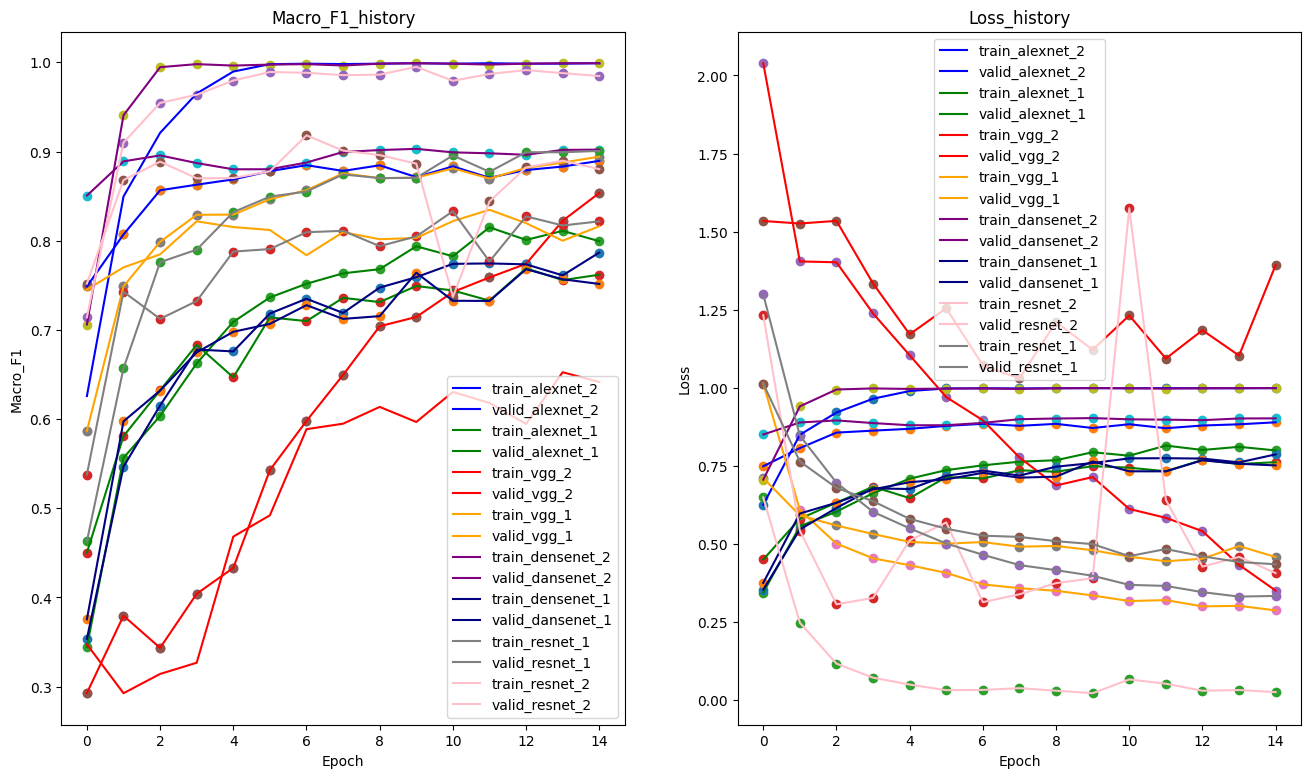

In [15]:
fig = plt.figure()
fig.set_size_inches(16, 9)

ax_1 = fig.add_subplot(1,2,1)

ax_1.plot(range(num_epochs), train_macro_f1_history_googlenet, label="train_alexnet_2", color="blue")
ax_1.plot(range(num_epochs), valid_macro_f1_history_googlenet, label="valid_alexnet_2", color="blue")
ax_1.scatter(range(num_epochs), valid_macro_f1_history_googlenet)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_googlenet)

ax_1.plot(range(num_epochs), train_macro_f1_history_googlenet_1, label="train_alexnet_1", color="green")
ax_1.plot(range(num_epochs), valid_macro_f1_history_googlenet_1, label="valid_alexnet_1", color="green")
ax_1.scatter(range(num_epochs), train_macro_f1_history_googlenet_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_googlenet_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_vgg, label="train_vgg_2", color="red")
ax_1.plot(range(num_epochs), valid_macro_f1_history_vgg, label="valid_vgg_2", color="red")
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg)
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg)

ax_1.plot(range(num_epochs), train_macro_f1_history_vgg_1, label="train_vgg_1", color="orange")
ax_1.plot(range(num_epochs), valid_macro_f1_history_vgg_1, label="valid_vgg_1", color="orange")
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg_1)
ax_1.scatter(range(num_epochs), train_macro_f1_history_vgg_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_inception, label="train_densenet_2", color="purple")
ax_1.plot(range(num_epochs), valid_macro_f1_history_inception, label="valid_dansenet_2", color="purple")
ax_1.scatter(range(num_epochs), train_macro_f1_history_inception)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_inception)

ax_1.plot(range(num_epochs), train_macro_f1_history_inception_1, label="train_densenet_1", color="navy")
ax_1.plot(range(num_epochs), valid_macro_f1_history_inception_1, label="valid_dansenet_1", color="navy")
ax_1.scatter(range(num_epochs), train_macro_f1_history_inception_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_inception_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_resnet_1, label="train_resnet_1", color="gray")
ax_1.plot(range(num_epochs), valid_macro_f1_history_resnet_1, label="valid_resnet_1", color="gray")
ax_1.scatter(range(num_epochs), train_macro_f1_history_resnet_1)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_resnet_1)

ax_1.plot(range(num_epochs), train_macro_f1_history_resnet, label="train_resnet_2", color="pink")
ax_1.plot(range(num_epochs), valid_macro_f1_history_resnet, label="valid_resnet_2", color="pink")
ax_1.scatter(range(num_epochs), train_macro_f1_history_resnet)
ax_1.scatter(range(num_epochs), valid_macro_f1_history_resnet)


plt.xlabel("Epoch")
plt.ylabel("Macro_F1")
plt.title("Macro_F1_history")
plt.legend()

ax_2 = fig.add_subplot(1,2,2)

ax_2.plot(range(num_epochs), train_macro_f1_history_googlenet, label="train_alexnet_2", color="blue")
ax_2.plot(range(num_epochs), valid_macro_f1_history_googlenet, label="valid_alexnet_2", color="blue")
ax_2.scatter(range(num_epochs), train_macro_f1_history_googlenet)
ax_2.scatter(range(num_epochs), valid_macro_f1_history_googlenet)

ax_2.plot(range(num_epochs), train_macro_f1_history_googlenet_1, label="train_alexnet_1", color="green")
ax_2.plot(range(num_epochs), valid_macro_f1_history_googlenet_1, label="valid_alexnet_1", color="green")
ax_2.scatter(range(num_epochs), train_macro_f1_history_googlenet_1)
ax_2.scatter(range(num_epochs), valid_macro_f1_history_googlenet_1)

ax_2.plot(range(num_epochs), train_loss_history_vgg, label="train_vgg_2", color="red")
ax_2.plot(range(num_epochs), valid_loss_history_vgg, label="valid_vgg_2", color="red")
ax_2.scatter(range(num_epochs), train_loss_history_vgg)
ax_2.scatter(range(num_epochs), valid_loss_history_vgg)

ax_2.plot(range(num_epochs), train_loss_history_vgg_1, label="train_vgg_1", color="orange")
ax_2.plot(range(num_epochs), valid_loss_history_vgg_1, label="valid_vgg_1", color="orange")
ax_2.scatter(range(num_epochs), train_loss_history_vgg_1)
ax_2.scatter(range(num_epochs), valid_loss_history_vgg_1)

ax_2.plot(range(num_epochs), train_macro_f1_history_inception, label="train_dansenet_2", color="purple")
ax_2.plot(range(num_epochs), valid_macro_f1_history_inception, label="valid_dansenet_2", color="purple")
ax_2.scatter(range(num_epochs), train_macro_f1_history_inception)
ax_2.scatter(range(num_epochs), valid_macro_f1_history_inception)

ax_2.plot(range(num_epochs), train_macro_f1_history_inception_1, label="train_dansenet_1", color="navy")
ax_2.plot(range(num_epochs), valid_macro_f1_history_inception_1, label="valid_dansenet_1", color="navy")
ax_2.scatter(range(num_epochs), train_macro_f1_history_inception_1)
ax_2.scatter(range(num_epochs), valid_macro_f1_history_inception_1)

ax_2.plot(range(num_epochs), train_loss_history_resnet, label="train_resnet_2", color="pink")
ax_2.plot(range(num_epochs), valid_loss_history_resnet, label="valid_resnet_2", color="pink")
ax_2.scatter(range(num_epochs), train_loss_history_resnet)
ax_2.scatter(range(num_epochs), valid_loss_history_resnet)

ax_2.plot(range(num_epochs), train_loss_history_resnet_1, label="train_resnet_1", color="gray")
ax_2.plot(range(num_epochs), valid_loss_history_resnet_1, label="valid_resnet_1", color="gray")
ax_2.scatter(range(num_epochs), train_loss_history_resnet_1)
ax_2.scatter(range(num_epochs), valid_loss_history_resnet_1)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss_history")
plt.legend()

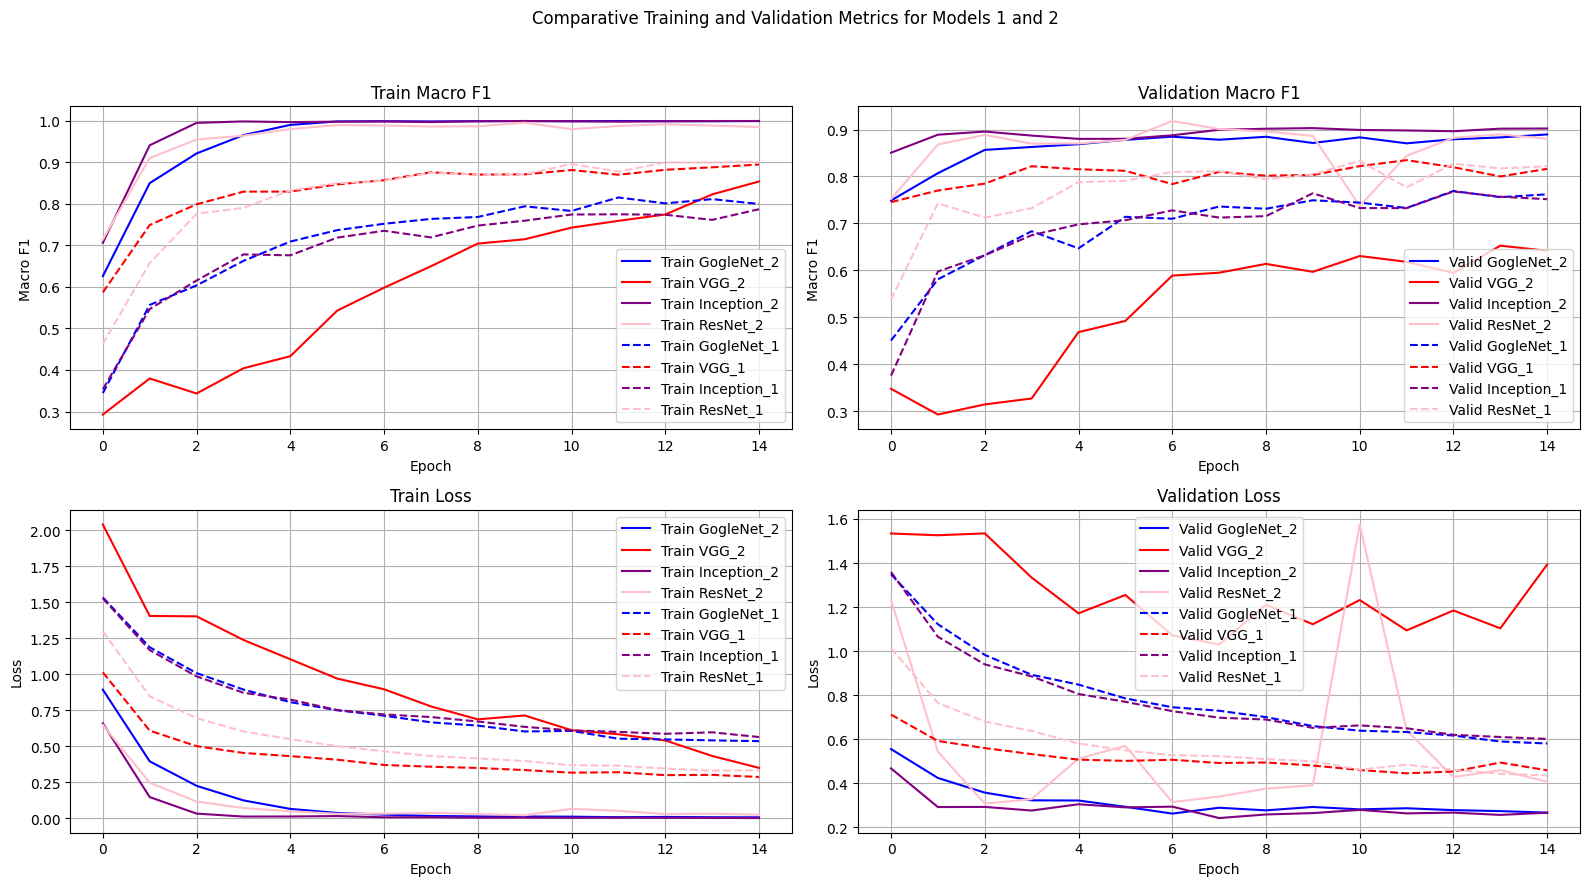

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
fig.suptitle("Comparative Training and Validation Metrics for Models 1 and 2")

# Подграфик для Train Macro F1 для всех моделей
ax_1 = axes[0, 0]
# Модели версии 2
ax_1.plot(range(num_epochs), train_macro_f1_history_googlenet, label="Train GogleNet_2", color="blue", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_vgg, label="Train VGG_2", color="red", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_inception, label="Train Inception_2", color="purple", linestyle='-')
ax_1.plot(range(num_epochs), train_macro_f1_history_resnet, label="Train ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_1.plot(range(num_epochs), train_macro_f1_history_googlenet_1, label="Train GogleNet_1", color="blue", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_vgg_1, label="Train VGG_1", color="red", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_inception_1, label="Train Inception_1", color="purple", linestyle='--')
ax_1.plot(range(num_epochs), train_macro_f1_history_resnet_1, label="Train ResNet_1", color="pink", linestyle='--')

ax_1.set_title("Train Macro F1")
ax_1.set_xlabel("Epoch")
ax_1.set_ylabel("Macro F1")
ax_1.legend()
ax_1.grid(True)

# Подграфик для Validation Macro F1 для всех моделей
ax_2 = axes[0, 1]
# Модели версии 2
ax_2.plot(range(num_epochs), valid_macro_f1_history_googlenet, label="Valid GogleNet_2", color="blue", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_vgg, label="Valid VGG_2", color="red", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_inception, label="Valid Inception_2", color="purple", linestyle='-')
ax_2.plot(range(num_epochs), valid_macro_f1_history_resnet, label="Valid ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_2.plot(range(num_epochs), valid_macro_f1_history_googlenet_1, label="Valid GogleNet_1", color="blue", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_vgg_1, label="Valid VGG_1", color="red", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_inception_1, label="Valid Inception_1", color="purple", linestyle='--')
ax_2.plot(range(num_epochs), valid_macro_f1_history_resnet_1, label="Valid ResNet_1", color="pink", linestyle='--')

ax_2.set_title("Validation Macro F1")
ax_2.set_xlabel("Epoch")
ax_2.set_ylabel("Macro F1")
ax_2.legend()
ax_2.grid(True)

# Подграфик для Train Loss для всех моделей
ax_3 = axes[1, 0]
# Модели версии 2
ax_3.plot(range(num_epochs), train_loss_history_googlenet, label="Train GogleNet_2", color="blue", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_vgg, label="Train VGG_2", color="red", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_inception, label="Train Inception_2", color="purple", linestyle='-')
ax_3.plot(range(num_epochs), train_loss_history_resnet, label="Train ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_3.plot(range(num_epochs), train_loss_history_googlenet_1, label="Train GogleNet_1", color="blue", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_vgg_1, label="Train VGG_1", color="red", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_inception_1, label="Train Inception_1", color="purple", linestyle='--')
ax_3.plot(range(num_epochs), train_loss_history_resnet_1, label="Train ResNet_1", color="pink", linestyle='--')

ax_3.set_title("Train Loss")
ax_3.set_xlabel("Epoch")
ax_3.set_ylabel("Loss")
ax_3.legend()
ax_3.grid(True)

# Подграфик для Validation Loss для всех моделей
ax_4 = axes[1, 1]
# Модели версии 2
ax_4.plot(range(num_epochs), valid_loss_history_googlenet, label="Valid GogleNet_2", color="blue", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_vgg, label="Valid VGG_2", color="red", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_inception, label="Valid Inception_2", color="purple", linestyle='-')
ax_4.plot(range(num_epochs), valid_loss_history_resnet, label="Valid ResNet_2", color="pink", linestyle='-')

# Модели версии 1
ax_4.plot(range(num_epochs), valid_loss_history_googlenet_1, label="Valid GogleNet_1", color="blue", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_vgg_1, label="Valid VGG_1", color="red", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_inception_1, label="Valid Inception_1", color="purple", linestyle='--')
ax_4.plot(range(num_epochs), valid_loss_history_resnet_1, label="Valid ResNet_1", color="pink", linestyle='--')

ax_4.set_title("Validation Loss")
ax_4.set_xlabel("Epoch")
ax_4.set_ylabel("Loss")
ax_4.legend()
ax_4.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Оставляем место для общего заголовка
plt.show()


# Сбор качества на тестовых данных

In [17]:
googlenet_1_test_loss, googlenet_1_test_macro_f1 = evaluate(googlenet_1, test_loader)
googlenet_2_test_loss, googlenet_2_test_macro_f1 = evaluate(googlenet, test_loader)

inception_1_test_loss, inception_1_test_macro_f1 = evaluate(inception_1, test_loader)
inception_2_test_loss, inception_2_test_macro_f1 = evaluate(inception, test_loader)

resnet_1_test_loss, resnet_1_test_macro_f1 = evaluate(resnet_1, test_loader)
resnet_2_test_loss, resnet_2_test_macro_f1 = evaluate(resnet, test_loader)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
vgg_1_test_loss, vgg_1_test_macro_f1 = evaluate(vgg_1, test_loader)
vgg_2_test_loss, vgg_2_test_macro_f1 = evaluate(vgg, test_loader)


Evaluation: 100%|██████████| 24/24 [00:08<00:00,  2.79it/s]


In [ ]:
results = [("GoogleNet обучение классификатора",googlenet_1_test_macro_f1),
           ("Densenet обучение классификатора",inception_1_test_macro_f1),
           ("Resnet обучение классификатора",resnet_1_test_macro_f1),
           ("Vgg обучение классификатора",vgg_1_test_macro_f1),
           ("GoogLeNet: обучение inception5b и fc", googlenet_2_test_macro_f1),
           ("Inception: обучение Mixed_7c и fc", inception_2_test_macro_f1),
           ("ResNet50: обучение layer4 и fc", resnet_2_test_macro_f1),
           ("VGG16: обучение последних 4-х сверточных слоев и классификатора",vgg_2_test_macro_f1)]

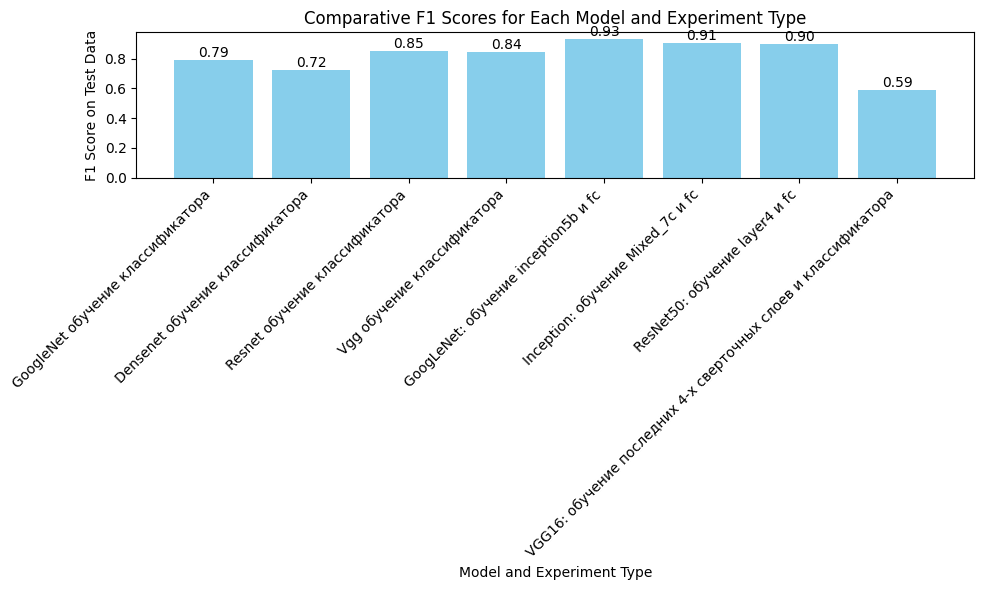

In [19]:
# Создание DataFrame для построения графика
df = pd.DataFrame(results, columns=['Model Experiment', 'F1 Score'])

# Построение столбчатой диаграммы
plt.figure(figsize=(10, 6))
bars = plt.bar(df['Model Experiment'], df['F1 Score'], color='skyblue')
plt.xlabel('Model and Experiment Type')
plt.ylabel('F1 Score on Test Data')
plt.title('Comparative F1 Scores for Each Model and Experiment Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Добавляем значения F1-меры на столбики
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.show()